# MNIST Classification using Neural Network

## Required Libraries

In [17]:
import numpy as np # Data Analysis
import matplotlib.pyplot as plt # Shows MNIST imaging
import torch # Core PyTorch library
import torch.nn as nn # Neural network class to define architecture
import torch.optim as optim # Optimization used in the training loop
from torch.utils.data import DataLoader, sampler # Feeds data into the model through batches
import torchvision.datasets as datasets # Source of the datasets
from torchvision import transforms # Provides image transformation tools

## Downloading Data

In [18]:
transform = transforms.Compose([transforms.ToTensor()]) # Transforms units to tensors
train_ds = datasets.MNIST(root='./data', download=True, train=True, transform=transform) # Downloads training data
test_ds = datasets.MNIST(root='./data', download=True, train=False, transform=transform) # Downloads testing data

In [19]:
print(train_ds) # Print the training dataset
print(test_ds) # Print the testing dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )


## Preprocessing Data

In [20]:
train_num = len(train_ds) # train_num is the number of samples
indices = list(range(train_num)) # Creates a list of indices for the training_data
np.random.shuffle(indices) # Randomizes the indices to reduce chances of bias
split = int(np.floor(0.2 * train_num)) # Calculates how much data should be in the testing data
train_idx, val_idx = indices[split:], indices[:split] # Split train set into training (80%) and validation set (20%)

In [21]:
print(len(train_idx)) # Prints number of samples in the training set
print(len(val_idx)) # Prints number of samples in the validation set

48000
12000


In [22]:
train_sampler = sampler.SubsetRandomSampler(train_idx) # Creates a random sample from the training set
val_sampler = sampler.SubsetRandomSampler(val_idx) # Creates a random sample from the validation set

train_dl = DataLoader(train_ds, batch_size=32, sampler=train_sampler) # Makes a training dataloader in batches of 32 
val_dl = DataLoader(train_ds, batch_size=32, sampler=val_sampler) # Makes a validation dataloader in batches of 32
test_dl = DataLoader(test_ds, batch_size=32) # Makes a testing dataloader in batches of 32

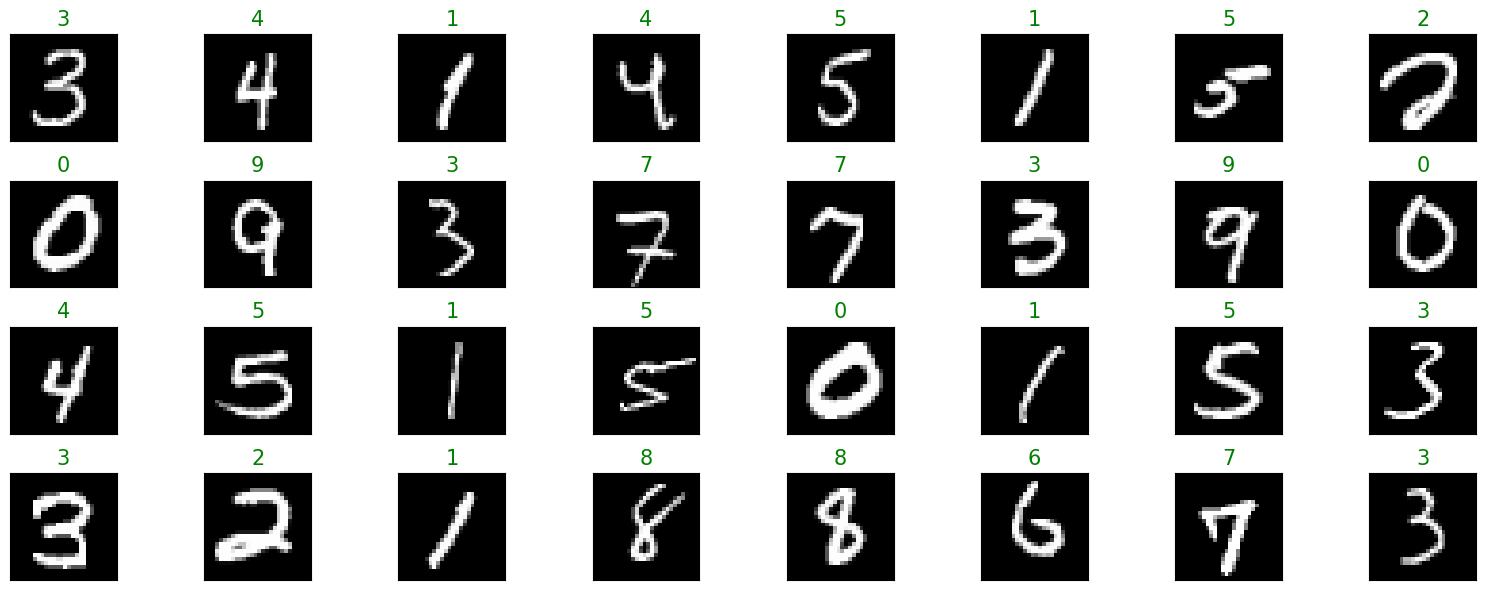

In [23]:
single_batch = next((iter(train_dl))) # Grabs one mini-batch of 32 images and labels
fig = plt.figure(figsize=(16, 6)) # Makes a plot of 16 by 6
for i in range(32): # Ranges from 0 to 32
    ax = fig.add_subplot(4, 8, i+1, xticks=[], yticks=[]) # Creates a subplot of 32 images
    image, label = single_batch[0][i].numpy().squeeze(), single_batch[1][i].numpy().squeeze() # Converts both image and label
    ax.imshow(image, cmap='gray') # Displays image in greyscale
    ax.set_title(label, fontsize=15, color='green') # Sets the color and size of the label
plt.tight_layout() # Ensures labels don't overlap
plt.show() # Displays the figure


## Define Model Architecture

In [24]:
class Network(nn.Module): # Creates a custom neural network
    def __init__(self): # Constructor
        super(Network, self).__init__() # Sets up the constructor
        self.hidden_0 = nn.Linear(784, 128) # First hidden layer of 784 pixels into 128
        self.hidden_1 = nn.Linear(128, 64) # Second hidden layer of 128 to 64
        self.output = nn.Linear(64, 10) # Output layer of 64 to 10 possible outputs (0 to 9)
        self.softmax = nn.LogSoftmax(dim=1) # Applies logsoftmax over the 10 outputs for classification
        self.activation = nn.ReLU() # Applies ReLU activation function to add non-linearity
        self.dropout = nn.Dropout(0.25) # Randomly drops 25% of the neurons during training to help prevent overfitting

    def forward(self, x): # Defines how the data flows in the neural network
        x = x.view(x.shape[0], -1) # Flattens 28 pixels by 28 pixel images into one 784 
        x = self.hidden_0(x) # Applies the first linear transformation
        x = self.activation(x) # Applies ReLU
        x = self.dropout(x) # Applies dropout
        x = self.hidden_1(x) # Applies the second linear transformation
        x = self.activation(x) # Applies ReLU
        x = self.dropout(x) # Applies dropout
        x = self.output(x) # Applies the third linear transformation
        x = self.softmax(x) # Does logsoftmax
        
        return x # Returns the loglikelihoods of 0-9 (Ex: [0.0, 0.1, 0.0, 0.0, 0.0, 0.7, 0.1, 0.1, 0.0, 0.0])

In [25]:
model = Network() # Instantiate the model
print(model) # Prints out the model

Network(
  (hidden_0): Linear(in_features=784, out_features=128, bias=True)
  (hidden_1): Linear(in_features=128, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=10, bias=True)
  (softmax): LogSoftmax(dim=1)
  (activation): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
)


In [26]:
loss_fn = nn.NLLLoss() # Defines the loss-function
optimizer = optim.Adam(model.parameters(), lr=0.001) # Utilizes the adam optimization

## Train And Validate Model

In [27]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' # Checks to see if CUDA support is available on the device
model.to(device) # Moves the model to the device
print(f'Moving \'model\' to [{device}] for training...') # Prints out confirmation that the model has been moved

Moving 'model' to [cpu] for training...


In [28]:
n_epochs = 10 # Sets the number of times the model will see the entire training set
train_losses = [] # Used to record the average training loss
val_losses = [] # Used to record the average testing loss
min_val_loss = np.inf # Sets the initial minimum validation loss to infinity
for epoch in range(1, n_epochs+1): # From epoch 1 to epoch 10
    epoch_train_loss = 0 # Reset training accumulators for new epoch
    epoch_val_loss = 0 # Reset testing accumulators for new epoch
    
    # Training loop
    model.train() # Sets the model to training mode
    for inputs, labels in train_dl: # Loops over the images and labels in the training batch
        inputs, labels = inputs.to(device), labels.to(device) # Moves data to `device` where model resides
        outputs = model(inputs) # Performs the forward pass for this batch
        loss = loss_fn(outputs, labels) # Computes the training batch loss
        optimizer.zero_grad() # Resets the gradients
        loss.backward() # Does back-propogation
        optimizer.step() # Updates weights
        epoch_train_loss += loss.item() # Keeps track of loss incurred for each training batch
        
    # Validation loop
    model.eval() # Sets the model to evaluation mode
    with torch.no_grad(): # Displays gradient tracking
        for inputs, labels in val_dl:  # Loops over the images and labels in the validation batch
            inputs, labels = inputs.to(device), labels.to(device) # Moves data to `device` where model resides
            outputs = model(inputs) # Performs the forward pass for this batch
            loss = loss_fn(outputs, labels) # Computes the batch's validation loss
            epoch_val_loss += loss.item() # Keeps track of loss incurred for each validation batch

        epoch_train_loss = epoch_train_loss/len(train_dl) # Computes training and validation loss incurred for this epoch
        epoch_val_loss = epoch_val_loss/len(val_dl) # Stores losses for each epoch for plotting later on
        train_losses.append(epoch_train_loss) # Appends the training loss to train_losses
        val_losses.append(epoch_val_loss) # Appends the testing loss to testing_losses

        print(f'Epoch {epoch}/{n_epochs}: train_loss = {epoch_train_loss:.8f}\tval_loss = {epoch_val_loss:.8f}') # Prints training and validation stats

        if epoch_val_loss < min_val_loss: # Saves the model if validation loss improved
            print(f'val_loss decreased ({min_val_loss:.8f}) --> ({epoch_val_loss:.8f}). Saving this model...') # Informs that validation loss improved and the model will be saved
            torch.save(model.state_dict(), 'MNIST_model.pth') # Save the model’s state dictionary to a new file
            min_val_loss = epoch_val_loss # Updates the best validation loss to the current epoch’s loss for next comparisons

Epoch 1/10: train_loss = 0.41024559	val_loss = 0.18283310
val_loss decreased (inf) --> (0.18283310). Saving this model...
Epoch 2/10: train_loss = 0.20003378	val_loss = 0.14019539
val_loss decreased (0.18283310) --> (0.14019539). Saving this model...
Epoch 3/10: train_loss = 0.15607657	val_loss = 0.12106274
val_loss decreased (0.14019539) --> (0.12106274). Saving this model...
Epoch 4/10: train_loss = 0.13149245	val_loss = 0.11248174
val_loss decreased (0.12106274) --> (0.11248174). Saving this model...
Epoch 5/10: train_loss = 0.11640325	val_loss = 0.10408088
val_loss decreased (0.11248174) --> (0.10408088). Saving this model...
Epoch 6/10: train_loss = 0.10323855	val_loss = 0.10392324
val_loss decreased (0.10408088) --> (0.10392324). Saving this model...
Epoch 7/10: train_loss = 0.09627174	val_loss = 0.10747059
Epoch 8/10: train_loss = 0.09102020	val_loss = 0.09367189
val_loss decreased (0.10392324) --> (0.09367189). Saving this model...
Epoch 9/10: train_loss = 0.08340642	val_loss =

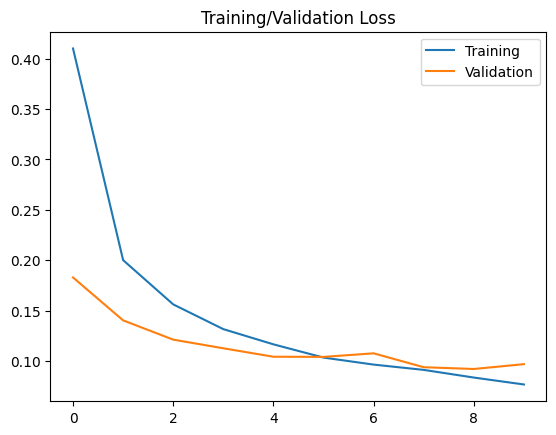

In [29]:
plt.title('Training/Validation Loss') # Gives a plot title
plt.plot(train_losses, label='Training') # Plots the training losses
plt.plot(val_losses, label='Validation') # Plots the validation losses
plt.legend() # Gives a plot legend
plt.show() # Displays the plot

## Test The Trained Model

In [30]:
weights = torch.load('MNIST_model.pth') # Loads the model with the trained wights
model = Network() # Creates a new instance of the neural network
model.load_state_dict(weights) # Loads the saved weights into the model

loss_fn = nn.NLLLoss() # Defines the loss function for computing test losses

device = 'cuda' if torch.cuda.is_available() else 'cpu' # Checks to see if CUDA support is available on the device
model = model.to(device) # Moves the model to the device

In [31]:
model.eval() # Sets the model to evaluation mode
test_loss = 0.0 # Tracks the total loss over the test set
test_acc = 0.0 # Tracks the total accuracy over the test set
correct_count = {i:0 for i in range(10)} # Creates a dictionary to store how many times each digit (0-9) appears 
total_count = {i:0 for i in range(10)} # Creates a dictionary to store how many times each digit is correctly predicted
with torch.no_grad(): # Disables gradient tracking
    for images, labels in test_dl: # Loops through batches from the test DataLoader
        images, labels = images.to(device), labels.to(device) # Moves both images and labels to the same device
        # make prediction
        outputs = model(images) # Feeds the test images through the trained model to get log-probabilities for each class
        pred_labels_proba = torch.exp(outputs) # Outputs log-probabilities
        loss = loss_fn(outputs, labels) # Computes the batch loss and keep track of running loss
        test_loss += loss.item() # Adds the batch loss to the running total test_loss
        _, pred_labels = torch.max(pred_labels_proba, dim=1) # Returns the maximum probability and the predicted label
        correct_preds = labels == pred_labels.squeeze() # Compares the true labels with the predicted labels
        test_acc += correct_preds.sum(dim=0)/len(correct_preds) # Adds the batch accuracy to the running total test_acc
        for i, label in enumerate(labels): # Loops through each sample in the batch
            label = label.item() # Retrieves the label
            total_count[label] += 1 # Updates how many times each true label occurred
            correct_count[label] += correct_preds.to('cpu').numpy()[i] # Updates how many times the model got it right for that label
    
test_loss = test_loss/len(test_dl) # Calculates the average test loss across all batches
test_acc = test_acc/len(test_dl) * 100 # Calculates the average test accuracy (in percentage)

print(f'overall test_loss = {test_loss:.8f}\noverall test_acc  = {test_acc:.2f}%\n') # Prints overall test statistics
for i, digit in enumerate(correct_count): # Iterates through each digit
    print(f'label {digit}: {correct_count[digit]}/{total_count[digit]}\t(accuracy = {correct_count[digit]/total_count[digit]:.2f}%)') # Prints certain statistics


overall test_loss = 0.08387676
overall test_acc  = 97.44%

label 0: 973/980	(accuracy = 0.99%)
label 1: 1125/1135	(accuracy = 0.99%)
label 2: 1000/1032	(accuracy = 0.97%)
label 3: 983/1010	(accuracy = 0.97%)
label 4: 957/982	(accuracy = 0.97%)
label 5: 851/892	(accuracy = 0.95%)
label 6: 932/958	(accuracy = 0.97%)
label 7: 999/1028	(accuracy = 0.97%)
label 8: 948/974	(accuracy = 0.97%)
label 9: 976/1009	(accuracy = 0.97%)


## Predicting Single Data Point

In [32]:
weights = torch.load('MNIST_model.pth') # Loads the model with the trained wights
model = Network() # Creates a new instance of the neural network
model.load_state_dict(weights) # Loads the saved weights into the model

device = 'cuda' if torch.cuda.is_available() else 'cpu' # Checks to see if CUDA support is available on the device
model = model.to(device) # Moves the model to the device

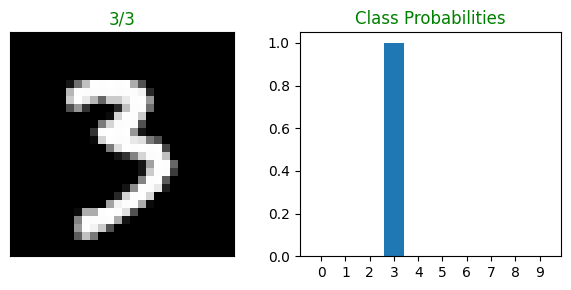

In [33]:
model.eval() # Sets the model to evaluation mode
with torch.no_grad(): # Disables gradient tracking
    batch = next(iter(test_dl)) # Takes one mini-batch from the test_dl DataLoader
    img_idx = 30 # Index selector
    image, label = batch[0][img_idx].to(device), batch[1][img_idx].to(device) # Selects the 31st image (img_idx = 30, zero-indexed) from this batch along with its true label
    proba = torch.exp(model(image)) # Runs the image through the model to get log probabilities
    _, pred_label = torch.max(proba, dim=1) # Finds the class with the highest probability
    
fig = plt.figure(figsize=(6, 3)) # Makes a new figure 6 by 3
ax1 = fig.add_subplot(1, 2, 1, xticks=[], yticks=[]) # Adds a subplot to plot the actual handwritten digit image.
image = image.squeeze().to('cpu').numpy() # Removes first dim, moves it to cpu and makes it a numpy array
ax1.imshow(image, cmap='gray') # Displays the image to greyscale
ax1.set_title(f'{pred_label.item()}/{label.item()}', color='green') # Shows the predicted label and true label as the title

proba = proba.squeeze().to('cpu').numpy() # Remove first dim, moves it to cpu and makes it a numpy array
ax2 = fig.add_subplot(1, 2, 2) # Adds a new plot
labels = [str(i) for i in range(10)] # Sets a label from 0 to 9
ax2.bar(range(len(labels)), proba) # Adds a probability range
ax2.set_xticks(range(len(labels))) # Adds the digits label
ax2.set_xticklabels(labels) # Sets the digits as an x-tick
ax2.set_title(f'Class Probabilities', color='green') # Sets the title
plt.tight_layout() # Makes the plot tightly packed
plt.show() # Displays the plot